In [1]:
from pulp import *

In [2]:
import init
import SBMLLint.common.constants as cn
from SBMLLint.common.simple_sbml import SimpleSBML
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [3]:
TOLERANCE = 0.0001

In [4]:
MODEL = "BIOMD0000000167_url.xml"
simple = SimpleSBML()
simple.initialize(os.path.join(cn.BIOMODELS_DIR, MODEL))

In [442]:
# SAMPLE_MODEL = "iCN718.xml"
SAMPLE_MODEL = "Recon3D.xml"
bigg_filepath = os.path.join(cn.BIGG_DIR, SAMPLE_MODEL)
simple = SimpleSBML()
simple.initialize(bigg_filepath)

In [7]:
simple.reactions

[PstatDimerisation: 2.00 Pstat_sol -> PstatDimer_sol; (Kf_PstatDimerisation * pow(Pstat_sol, 2) + -(Kr_PstatDimerisation * PstatDimer_sol)) * sol,
 statDephosphorylation: Pstat_nuc -> stat_nuc; Kcat_dephos * statPhosphatase_nuc * Pstat_nuc * (1 / (Km_dephos + Pstat_nuc)) * nuc,
 statPhosphorylation: stat_sol -> Pstat_sol + species_test; Kcat_phos * statKinase_sol * stat_sol * (1 / (Km_phos + stat_sol)) * sol,
 PstatDimerisationNuc: 2.00 Pstat_nuc -> PstatDimer_nuc; (Kf_PstatDimerisation * pow(Pstat_nuc, 2) + -(Kr_PstatDimerisation * PstatDimer_nuc)) * nuc,
 PstatDimer__import: PstatDimer_sol -> PstatDimer_nuc; PstatDimer_impMax * PstatDimer_sol * (1 / (Kpsd_imp + PstatDimer_sol)) * nm,
 stat_export: stat_sol -> stat_nuc; nuc * stat_expMax * stat_nuc * (1 / (Ks_exp + stat_nuc)) * nm,
 stat_import: stat_sol -> stat_nuc; nuc * stat_impMax * stat_sol * (1 / (Ks_imp + stat_sol)) * nm]

In [8]:
s = StoichiometryMatrix(simple)
mat = s.stoichiometry_matrix
mat.shape

(7, 7)

In [7]:
# # reduce mat and see what happens
# submat = mat[['reaction9', 'reaction10']]
# print(submat)

In [67]:
prob = LpProblem("Finding_Unconserved_Metabolites", LpMaximize)
milp_begin = time.time()
species = list(mat.index)
species_inclusion = pulp.LpVariable.dicts("species", species, cat="Binary")
species_mass = pulp.LpVariable.dicts("mass", species, cat="Continuous")
# objective function (to maximize the number of species)
prob += lpSum([species_inclusion[i] for i in species])
# constraint 1 (for each reaction, the sum(stoichiometry[i]*mass[i])=0)
for reaction in mat.columns:
  prob += lpSum(sum([mat[reaction][species]*species_mass[species] for species in species_inclusion])) == 0
# constraint 2 (species_inclusion is less than or equal to mass of each species)
# prob += lpSum(species_inclusion[species] <= species_mass[species] for speices in species_inclusion)
for species in species_mass.keys():
  prob += species_inclusion[species] <= species_mass[species]
###########
# solve problem
milp_middle = time.time()
prob.solve()
print("Status:", LpStatus[prob.status])
milp_end = time.time()

Status: Optimal


In [9]:
milp_time = milp_end - milp_begin
print("MILP took %f" % milp_time)

MILP took 0.044254


In [10]:
res = []
for v in prob.variables()[round(len(prob.variables())/2):]:
  if v.varValue == 0.0:
    res.append(v.name[8:])

In [11]:
ext_res = []
for v in prob.variables():
  if v.varValue == 0.0:
    ext_res.append(v.name)

In [12]:
print("Among %d species %d are unconserved." % (len(mat.index), len(res)))

Among 7 species 1 are unconserved.


In [13]:
# find reactions that contains all unconserved metabolites
reaction = set()
# from stoichiometry matrix, choose metabolites only, and remove null reactions for the metabolites
unconserved_mat = mat.T[res].T

In [14]:
unconserved_mat.shape

(1, 7)

In [15]:
red_uncons_mat = unconserved_mat.loc[:,(unconserved_mat!=0).any()]

In [16]:
red_uncons_mat.shape

(1, 1)

In [431]:
# from i718 model
# R_SEAHCYSHYD: M_h2o_c + M_seahcys_c -> M_adn_c + M_selhcys_c
# R_SEAHCYSHYD_1: M_h2o_c + M_seahcys_c -> M_adn_c + M_h_c + M_selhcys_c
"M_h_c" in res

False

(array([7.359e+03, 7.370e+02, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1. ,  6.7, 12.4, 18.1, 23.8, 29.5, 35.2, 40.9, 46.6, 52.3, 58. ]),
 <a list of 10 Patch objects>)

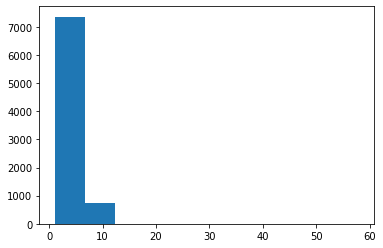

In [502]:
nonzero_vals = []
for col in red_uncons_mat.columns:
  num_nonzero = (red_uncons_mat[col]!=0).sum()
  if num_nonzero ==0:
    print("Error! Error!")
  else: 
    nonzero_vals.append(num_nonzero)
plt.hist(nonzero_vals)

In [505]:
len(red_uncons_mat.columns)

8102

In [489]:
red_uncons_mat

,R_24_25DHVITD3tm,R_25HVITD3t,R_COAtl,R_24_25VITD3Hm,R_11DOCRTSLtr,R_13DAMPPOX,R_24_25DHVITD3t,R_25VITD2Hm,R_2AMACHYD,R_2AMACSULT,...,R_3DHCDCHOLabc,R_3DHCDCHOLt,R_3DHCDCHOLt2,R_3DHDCAS,R_3DHDCAt,R_3DHLCAt,R_ACMPGLUTTRsc,R_FVSCOAhc,R_MDZGLChr,R_TMACMPhr
M_11docrtsl_c,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M_11docrtsl_e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M_11docrtsl_m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M_11docrtsl_r,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M_11docrtstrn_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_zym_int2_r,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M_zymst_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M_zymst_r,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M_zymstnl_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
sigma

array([2.61469658e+00, 2.46912358e+00, 2.16281004e+00, 1.33790409e+00,
       1.18447891e+00, 4.42793057e-01, 2.38794632e-32])

In [5]:
## test from memote LP
from numpy.linalg import svd

In [9]:
matrix = np.atleast_2d(mat.T)

In [10]:
_, sigma, vh = svd(matrix)

In [11]:
atol = 1e-13
rtol = 0.0
tol = max(atol, rtol*sigma[0])
num_nonzero = (sigma >= tol).sum()
print(num_nonzero)

6


In [23]:
# left_ns = vh[num_nonzero:].conj().T
left_ns = pd.DataFrame(vh[num_nonzero:].conj().T, index=mat.index)
print(left_ns)

                       0
species_test    0.000000
PstatDimer_nuc  0.577350
PstatDimer_sol  0.577350
Pstat_sol       0.288675
stat_nuc        0.288675
Pstat_nuc       0.288675
stat_sol        0.288675


In [29]:
pd.DataFrame(np.array([0, 2, 2, 1, 1, 1, 1]), index=mat.index).T

,species_test,PstatDimer_nuc,PstatDimer_sol,Pstat_sol,stat_nuc,Pstat_nuc,stat_sol
0,0,2,2,1,1,1,1


In [30]:
result_back = left_ns.T.dot(mat)
result_back

,PstatDimerisation,statDephosphorylation,statPhosphorylation,PstatDimerisationNuc,PstatDimer__import,stat_export,stat_import
0,1.110223e-16,-1.665335e-16,1.110223e-16,3.330669e-16,0.0,-1.665335e-16,-1.665335e-16


In [31]:
# solve inconsistent net stoichiometry
mat

,PstatDimerisation,statDephosphorylation,statPhosphorylation,PstatDimerisationNuc,PstatDimer__import,stat_export,stat_import
species_test,0.0,0.0,1.0,0.0,0.0,0.0,0.0
PstatDimer_nuc,0.0,0.0,0.0,1.0,1.0,0.0,0.0
PstatDimer_sol,1.0,0.0,0.0,0.0,-1.0,0.0,0.0
Pstat_sol,-2.0,0.0,1.0,0.0,0.0,0.0,0.0
stat_nuc,0.0,1.0,0.0,0.0,0.0,1.0,1.0
Pstat_nuc,0.0,-1.0,0.0,-2.0,0.0,0.0,0.0
stat_sol,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0


In [32]:
k_mat.index[:-1]

Index(['species_test', 'PstatDimer_nuc', 'PstatDimer_sol', 'Pstat_sol',
       'stat_nuc', 'Pstat_nuc'],
      dtype='object')

In [36]:
# To verify Gevorgyan algorithm
k_mat = pd.DataFrame(np.array([0.0, -1.0, -1.0, 1.0, 0.0, 0.0]), index=['A', 'Ap', 'B', 'Bp', 'C', 'Cp'])[0]
prob_min_net_stoi = LpProblem("Finding_Minimal_Net_Stoichiometry", LpMinimize)
milp_min_net_stoi_begin = time.time()
species = list(k_mat.index)
species_inclusion_net_stoi = pulp.LpVariable.dicts("include", species, cat="Binary")
species_weight_net_stoi = pulp.LpVariable.dicts("weight", species, lowBound=atol, cat="Continuous")
# objective function to minimize
prob_min_net_stoi += lpSum([species_inclusion_net_stoi[i] for i in species])
# constraint 1 (for each metabolite, species_weight_net_stoi[i]*species_inclusion_net_stoi[i])=0)
# for metabolite in k_mat.index:
prob_min_net_stoi += lpSum(species_weight_net_stoi[metabolite]*k_mat[metabolite] for metabolite in k_mat.index)==0
# constraint 2 (species_inclusion is less than or equal to mass of each species)
for species in species_weight_net_stoi.keys():
  prob_min_net_stoi += species_weight_net_stoi[species] <= species_inclusion_net_stoi[species]
# constraint 3 (at least one element nonzero)
prob_min_net_stoi += sum(species_inclusion_net_stoi[metabolite] for metabolite in k_mat.index) >= 1
###########
# # solve problem
prob_min_net_stoi.solve()
print("Status:", LpStatus[prob_min_net_stoi.status])
for v in prob_min_net_stoi.variables():
  print("%s has value: %.20f" % (v.name, v.varValue))
  print(v.varValue == 0.0)

Status: Optimal
include_A has value: 0.00000000000000000000
True
include_Ap has value: 0.00000000000000000000
True
include_B has value: 0.00000000000000000000
True
include_Bp has value: 0.00000000000000000000
True
include_C has value: 0.00000000000000000000
True
include_Cp has value: 1.00000000000000000000
False
weight_A has value: 0.00000000000010000000
False
weight_Ap has value: 0.00000000000010000000
False
weight_B has value: 0.00000000000010000000
False
weight_Bp has value: 0.00000000000010000000
False
weight_C has value: 0.00000000000010000000
False
weight_Cp has value: 0.00000000000010000000
False


In [35]:
prob_min_net_stoi

Finding_Minimal_Net_Stoichiometry:
MINIMIZE
1*include_A + 1*include_Ap + 1*include_B + 1*include_Bp + 1*include_C + 1*include_Cp + 0
SUBJECT TO
_C1: - weight_Ap - weight_B + weight_Bp = 0

_C2: - include_A + weight_A <= 0

_C3: - include_Ap + weight_Ap <= 0

_C4: - include_B + weight_B <= 0

_C5: - include_Bp + weight_Bp <= 0

_C6: - include_C + weight_C <= 0

_C7: - include_Cp + weight_Cp <= 0

_C8: include_A + include_Ap + include_B + include_Bp + include_C + include_Cp
 >= 1

VARIABLES
0 <= include_A <= 1 Integer
0 <= include_Ap <= 1 Integer
0 <= include_B <= 1 Integer
0 <= include_Bp <= 1 Integer
0 <= include_C <= 1 Integer
0 <= include_Cp <= 1 Integer
1e-13 <= weight_A Continuous
1e-13 <= weight_Ap Continuous
1e-13 <= weight_B Continuous
1e-13 <= weight_Bp Continuous
1e-13 <= weight_C Continuous
1e-13 <= weight_Cp Continuous

In [42]:
k_mat

species_test      0.000000
PstatDimer_nuc    0.577350
PstatDimer_sol    0.577350
Pstat_sol         0.288675
stat_nuc          0.288675
Pstat_nuc         0.288675
stat_sol          0.288675
Name: 0, dtype: float64

In [44]:
# to find minimal net stoichiometry
# from Gevorgyan formula (13), k_mat is is K_met, y is species_weight_net_stoi, k_i is species_inclusion_net_stoi
# this runs for each column of left_ns, so here, just select first column
k_mat = left_ns[0]
prob_min_net_stoi = LpProblem("Finding_Minimal_Net_Stoichiometry", LpMinimize)
milp_min_net_stoi_begin = time.time()
species = list(k_mat.index)
species_inclusion_net_stoi = pulp.LpVariable.dicts("include", species, cat="Binary")
species_weight_net_stoi = pulp.LpVariable.dicts("weight", species, lowBound=0.0, cat="Continuous")
# objective function to minimize
prob_min_net_stoi += lpSum([species_inclusion_net_stoi[i] for i in species])
# constraint 1 (for each metabolite, species_weight_net_stoi[i]*species_inclusion_net_stoi[i])=0)
# for metabolite in k_mat.index:
prob_min_net_stoi += lpSum(species_weight_net_stoi[metabolite]*k_mat[metabolite] for metabolite in k_mat.index)==0
# constraint 2 (species_inclusion is less than or equal to mass of each species)
for species in species_weight_net_stoi.keys():
  prob_min_net_stoi += species_weight_net_stoi[species] <= species_inclusion_net_stoi[species] 
# constraint 3 (at least one element nonzero)
prob_min_net_stoi += sum(species_inclusion_net_stoi[metabolite] for metabolite in k_mat.index) >= 1
###########
# # solve problem
prob_min_net_stoi.solve()
print("Status:", LpStatus[prob_min_net_stoi.status])

Status: Optimal


In [47]:
for v in prob_min_net_stoi.variables():
  print("%s has value: %.10f" % (v.name, v.varValue))

include_PstatDimer_nuc has value: 0.0000000000
include_PstatDimer_sol has value: 0.0000000000
include_Pstat_nuc has value: 0.0000000000
include_Pstat_sol has value: 0.0000000000
include_species_test has value: 0.0000000000
include_stat_nuc has value: 0.0000000000
include_stat_sol has value: 1.0000000000
weight_PstatDimer_nuc has value: 0.0000000000
weight_PstatDimer_sol has value: 0.0000000000
weight_Pstat_nuc has value: 0.0000000000
weight_Pstat_sol has value: 0.0000000000
weight_species_test has value: 0.0000000000
weight_stat_nuc has value: 0.0000000000
weight_stat_sol has value: 0.0000000000


In [46]:
prob_min_net_stoi

Finding_Minimal_Net_Stoichiometry:
MINIMIZE
1*include_PstatDimer_nuc + 1*include_PstatDimer_sol + 1*include_Pstat_nuc + 1*include_Pstat_sol + 1*include_species_test + 1*include_stat_nuc + 1*include_stat_sol + 0
SUBJECT TO
_C1: 0.57735026919 weight_PstatDimer_nuc + 0.57735026919 weight_PstatDimer_sol
 + 0.288675134595 weight_Pstat_nuc + 0.288675134595 weight_Pstat_sol
 + 0.288675134595 weight_stat_nuc + 0.288675134595 weight_stat_sol = 0

_C2: - include_species_test + weight_species_test <= 0

_C3: - include_PstatDimer_nuc + weight_PstatDimer_nuc <= 0

_C4: - include_PstatDimer_sol + weight_PstatDimer_sol <= 0

_C5: - include_Pstat_sol + weight_Pstat_sol <= 0

_C6: - include_stat_nuc + weight_stat_nuc <= 0

_C7: - include_Pstat_nuc + weight_Pstat_nuc <= 0

_C8: - include_stat_sol + weight_stat_sol <= 0

_C9: include_PstatDimer_nuc + include_PstatDimer_sol + include_Pstat_nuc
 + include_Pstat_sol + include_species_test + include_stat_nuc
 + include_stat_sol >= 1

VARIABLES
0 <= include_P

In [60]:
left_ns

,0
species_test,0.000000
stat_nuc,-0.288675
PstatDimer_sol,-0.577350
Pstat_sol,-0.288675
PstatDimer_nuc,-0.577350
stat_sol,-0.288675
Pstat_nuc,-0.288675


In [527]:
left_ns

array([[2.88675135e-01],
       [5.77350269e-01],
       [2.88675135e-01],
       [1.06315346e-16],
       [5.77350269e-01],
       [2.88675135e-01],
       [2.88675135e-01]])